In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-02-26 15:48:23--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  5.12MB/s    in 0.2s    

2022-02-26 15:48:23 (5.12 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MachineLearningIntegration").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [6]:
!pip install prophet

     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
  Created wheel for Prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640663 sha256=2e122869e26e879284bc6cf3188dc819fbbf77d47a6359ac8053a0868cebd4b9
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built Prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [72]:
# dependecies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import meanabs
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from pandas import to_datetime
from pandas.tseries.offsets import DateOffset as DateOffset
from datetime import datetime
import itertools
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# filepath
# path_1 = "Data/BicycleSales_2016-2021_cleaned.xlsx"
path_1 = '/content/gdrive/MyDrive/School/Georgia Tech/Data Science & Analytics Bootcamp/GT_DS_HW/Project-4_MachineLearningIntegration/Data/BicycleSales_2016-2021_cleaned.xlsx'

# read data
sales_df = pd.read_excel(path_1)

In [9]:
# group and pivot invoiced quantity by date and material
# split Month into separate month and year components
sales_df[["Month", "Year"]] = sales_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
sales_df["Month"] = sales_df["Year"] + "-" + sales_df["Month"]

# group by date, sold-to, material
sales_gb_df = sales_df.groupby(
    ['Month', "Material"])[["Invoiced Quantity"]].sum()

print(sales_gb_df)

                    Invoiced Quantity
Month   Material                     
2016-01 IB22993000                  2
        IB25400000                  4
        IB59763900                  2
        IB63464200                  8
        IB63828900                  4
...                               ...
2021-12 TB96908400                 17
        TB96909000                 94
        TB96909200                  7
        TB96909300                 12
        TB96910100                 45

[19407 rows x 1 columns]


In [10]:
# pivot sold to and material
sales_pivot_df = pd.pivot_table(sales_gb_df,
                           values = 'Invoiced Quantity',
                           index = 'Month',
                           columns = 'Material',
                           aggfunc=np.sum,
                           fill_value = 0
                                )

sales_pivot_df = sales_pivot_df.reset_index()
sales_pivot_df['Month'] = to_datetime(sales_pivot_df['Month'])
sales_pivot_df = sales_pivot_df.set_index(['Month'])

print(sales_pivot_df)

Material    IB00026200  IB00026400  ...  TB97613100  TB97613200
Month                               ...                        
2016-01-01           0           0  ...           0           0
2016-02-01           0           0  ...           0           0
2016-03-01           0           0  ...           0           0
2016-04-01           0           0  ...           0           0
2016-05-01           0           0  ...           0           0
...                ...         ...  ...         ...         ...
2021-08-01           0           0  ...           0           0
2021-09-01           0           0  ...           0           0
2021-10-01           0           0  ...           0           0
2021-11-01           0           0  ...           0           0
2021-12-01           0           0  ...           0           0

[72 rows x 868 columns]


In [11]:
sales_1_df = sales_pivot_df[['TB96805000']]
sales_1_df.rename(columns={'TB96805000':'Sales'}, inplace = True)
# sales_1_df.to_csv("Output/Sales.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
sales_1_df

Material,Sales
Month,
2016-01-01,8
2016-02-01,22
2016-03-01,37
2016-04-01,106
2016-05-01,313
...,...
2021-08-01,3127
2021-09-01,0
2021-10-01,0


### Prohpet

In [123]:
m = Prophet(seasonality_mode='additive')
# df = sales_1_df.iloc[:,each].to_frame().reset_index()
# material = df.columns[1]
df = sales_1_df.reset_index()

df.columns = ['ds', 'y']
m.fit(df)
future = m.make_future_dataframe(periods=24, freq='M')

fcst = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [126]:
prophet_df = fcst[{'ds', 'yhat'}]
prophet_df.columns = ['Month', 'Prophet']
prophet_df = prophet_df.set_index(['Month'])
prophet_df['Prophet'] = prophet_df['Prophet'].round(decimals=0)
prophet_df['Prophet'] = prophet_df['Prophet'].apply(np.int64)
# prophet_df.to_csv("Output/Prophet.csv")
prophet_df

,Prophet
Month,
2016-01-01,380
2016-02-01,-76
2016-03-01,18
2016-04-01,117
2016-05-01,117
...,...
2023-07-31,667
2023-08-31,101
2023-09-30,567


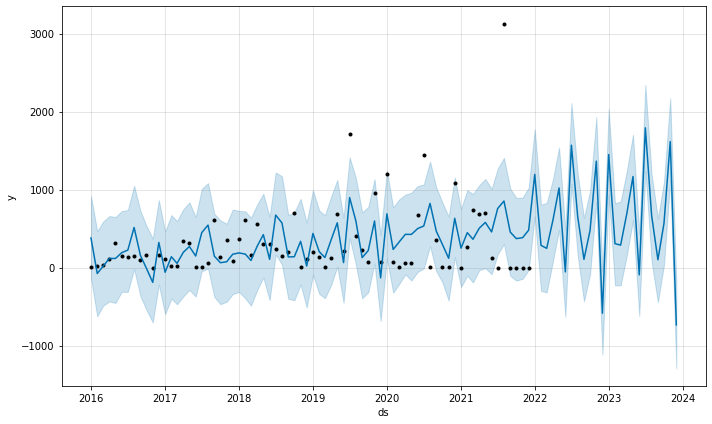

In [127]:
# plot
fig = m.plot(fcst)

In [149]:
# performance
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

cutoffs = pd.to_datetime(['2017-12-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='731 days', parallel="processes")

df_cv

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8f47c8a610>
INFO:prophet:n_changepoints greater than number of observations. Using 18.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-01,220.567819,37.301492,387.619753,362,2017-12-01
1,2018-02-01,226.707859,50.959683,399.890777,606,2017-12-01
2,2018-03-01,232.443378,52.709312,397.776327,162,2017-12-01
3,2018-04-01,239.542456,77.624434,412.892540,561,2017-12-01
4,2018-05-01,245.862633,73.609363,408.774444,306,2017-12-01
5,2018-06-01,251.100196,75.176471,426.095686,300,2017-12-01
6,2018-07-01,257.170032,76.152495,419.662421,233,2017-12-01
7,2018-08-01,263.652902,96.589156,431.826189,154,2017-12-01
8,2018-09-01,271.664730,113.761113,453.545184,205,2017-12-01
9,2018-10-01,276.359504,107.585329,477.210913,700,2017-12-01


In [150]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,62 days,81932.794987,286.239052,260.362161,0.508296,0.508296,0.698266,0.5
1,90 days,74412.398788,272.786361,224.867759,0.530365,0.530365,0.634082,0.5
2,121 days,54148.611144,232.698541,195.950461,0.503922,0.503922,0.580139,0.5
3,151 days,53475.727866,231.248195,190.797456,0.384768,0.384768,0.510521,0.5
4,182 days,3003.846867,54.807361,54.518585,0.179763,0.179763,0.197703,1.0
5,212 days,1487.690635,38.570593,36.534918,0.133367,0.133367,0.138041,1.0
6,243 days,6303.974705,79.397574,66.911467,0.407883,0.407883,0.311855,1.0
7,274 days,8233.972615,90.741240,88.158816,0.518613,0.518613,0.402402,1.0
8,304 days,91957.728169,303.245327,245.152613,0.465197,0.465197,0.573755,0.5
9,335 days,127857.868484,357.572186,349.882251,20.025744,20.025744,1.385643,0.0


In [89]:
# Hyperparameter tuning
param_grid = {  
    'changepoint_prior_scale': [0.001, .005, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='731 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8f47c53050>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8f47c3b310>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.Proce

    changepoint_prior_scale  ...         rmse
0                     0.001  ...   716.095159
1                     0.001  ...   714.607563
2                     0.001  ...   728.035379
3                     0.001  ...   760.248979
4                     0.001  ...   741.502639
5                     0.001  ...   841.597651
6                     0.001  ...   751.163702
7                     0.001  ...   954.237116
8                     0.005  ...   715.775148
9                     0.005  ...   714.040033
10                    0.005  ...   728.109634
11                    0.005  ...   750.607369
12                    0.005  ...   740.844875
13                    0.005  ...   813.033154
14                    0.005  ...   750.300672
15                    0.005  ...  1030.594899
16                    0.010  ...   716.025094
17                    0.010  ...   713.598198
18                    0.010  ...   728.357299
19                    0.010  ...   747.813037
20                    0.010  ...  

In [99]:
# Identify best hyperparameter
best_parameters = tuning_results.iloc[tuning_results['rmse'].idxmin(),:]
cps = best_parameters['changepoint_prior_scale']
sps = best_parameters['seasonality_prior_scale']
sm = best_parameters['seasonality_mode']
best_parameters

changepoint_prior_scale              0.01
seasonality_prior_scale              0.01
seasonality_mode           multiplicative
rmse                           713.598198
Name: 17, dtype: object

In [130]:
m = Prophet(seasonality_mode=sm, changepoint_prior_scale=cps, seasonality_prior_scale=sps)
# df = sales_1_df.iloc[:,each].to_frame().reset_index()
# material = df.columns[1]
df = sales_1_df.reset_index()

df.columns = ['ds', 'y']
m.fit(df)
future = m.make_future_dataframe(periods=24, freq='M')

fcst_tuned = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [138]:
prophet_tuned_df = fcst_tuned[{'ds', 'yhat'}]
prophet_tuned_df.columns = ['Month', 'Prophet_tuned']
prophet_tuned_df = prophet_tuned_df.set_index(['Month'])
prophet_tuned_df['Prophet_tuned'] = prophet_tuned_df['Prophet_tuned'].round(decimals=0)
prophet_tuned_df['Prophet_tuned'] = prophet_tuned_df['Prophet_tuned'].apply(np.int64)
# prophet_df.to_csv("Output/Prophet.csv")
prophet_tuned_df

,Prophet_tuned
Month,
2016-01-01,95
2016-02-01,101
2016-03-01,107
2016-04-01,113
2016-05-01,119
...,...
2023-07-31,649
2023-08-31,651
2023-09-30,657


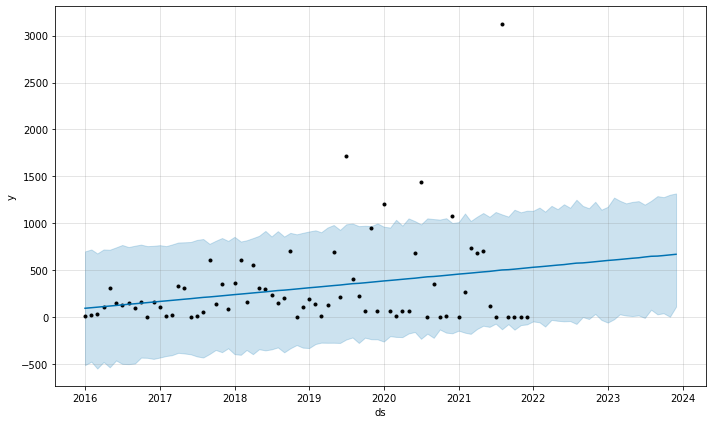

In [139]:
# plot
fig = m.plot(fcst_tuned)

In [134]:
# performance
cutoffs = pd.to_datetime(['2019-12-01','2020-12-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")

df_cv

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8f488ccd10>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-01-01,444.945897,87.791165,802.239377,1202,2019-12-01
1,2020-02-01,453.364833,106.118975,811.513015,68,2019-12-01
2,2020-03-01,459.640656,121.210634,844.828468,12,2019-12-01
3,2020-04-01,469.062072,101.466233,831.921643,64,2019-12-01
4,2020-05-01,477.984337,142.606145,837.148723,63,2019-12-01
5,2020-06-01,484.089537,115.963563,843.229285,679,2019-12-01
6,2020-07-01,496.425593,148.520767,860.684637,1441,2019-12-01
7,2020-08-01,500.723979,136.986339,838.958677,7,2019-12-01
8,2020-09-01,509.359338,144.211563,854.862499,355,2019-12-01
9,2020-10-01,517.451925,121.042432,867.600439,4,2019-12-01


In [122]:
df_p = performance_metrics(df_cv)
df_p

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,31 days,4.096729e+05,640.056979,626.627312,inf,1.459672,0.00
1,62 days,1.009675e+05,317.753899,308.256015,3.261615,1.038891,0.50
2,90 days,7.734360e+04,278.107177,270.015520,2.990594,0.705726,0.75
3,91 days,1.270509e+05,356.442015,339.707841,18.808723,1.135394,0.50
4,121 days,1.147688e+05,338.775424,309.195118,18.776329,1.091494,0.50
5,122 days,9.661535e+04,310.830099,287.905826,3.289182,0.902258,0.50
6,151 days,9.901617e+04,314.668351,294.668244,3.295053,0.909972,0.50
7,152 days,1.030845e+05,321.067796,299.629376,3.424032,0.917185,0.50
8,182 days,1.696170e+05,411.845846,411.833795,4.996373,1.397111,0.50
9,183 days,1.025060e+05,320.165653,301.796859,1.846374,0.797600,1.00


### load to postgres RDS

In [142]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://database-1.cc8swew422eu.us-east-1.rds.amazonaws.com:5432/postgres"
config = {"user":"pgadmin", 
          "password": "postgres", 
          "driver":"org.postgresql.Driver"}

In [143]:
#Create PySpark DataFrame from Pandas
prophet_sparkDF=spark.createDataFrame(prophet_df.reset_index()) 
prophet_sparkDF.printSchema()
prophet_sparkDF.show()

root
 |-- Month: timestamp (nullable = true)
 |-- Prophet: long (nullable = true)

+-------------------+-------+
|              Month|Prophet|
+-------------------+-------+
|2016-01-01 00:00:00|    380|
|2016-02-01 00:00:00|    -76|
|2016-03-01 00:00:00|     18|
|2016-04-01 00:00:00|    117|
|2016-05-01 00:00:00|    117|
|2016-06-01 00:00:00|    191|
|2016-07-01 00:00:00|    224|
|2016-08-01 00:00:00|    514|
|2016-09-01 00:00:00|    157|
|2016-10-01 00:00:00|    -11|
|2016-11-01 00:00:00|   -190|
|2016-12-01 00:00:00|    323|
|2017-01-01 00:00:00|    -60|
|2017-02-01 00:00:00|    139|
|2017-03-01 00:00:00|     54|
|2017-04-01 00:00:00|    196|
|2017-05-01 00:00:00|    270|
|2017-06-01 00:00:00|    148|
|2017-07-01 00:00:00|    449|
|2017-08-01 00:00:00|    544|
+-------------------+-------+
only showing top 20 rows



In [144]:
#Create PySpark DataFrame from Pandas
sales_1_sparkDF=spark.createDataFrame(sales_1_df.reset_index()) 
sales_1_sparkDF.printSchema()
sales_1_sparkDF.show()

root
 |-- Month: timestamp (nullable = true)
 |-- Sales: long (nullable = true)

+-------------------+-----+
|              Month|Sales|
+-------------------+-----+
|2016-01-01 00:00:00|    8|
|2016-02-01 00:00:00|   22|
|2016-03-01 00:00:00|   37|
|2016-04-01 00:00:00|  106|
|2016-05-01 00:00:00|  313|
|2016-06-01 00:00:00|  149|
|2016-07-01 00:00:00|  135|
|2016-08-01 00:00:00|  150|
|2016-09-01 00:00:00|  101|
|2016-10-01 00:00:00|  167|
|2016-11-01 00:00:00|    0|
|2016-12-01 00:00:00|  160|
|2017-01-01 00:00:00|  112|
|2017-02-01 00:00:00|   15|
|2017-03-01 00:00:00|   23|
|2017-04-01 00:00:00|  336|
|2017-05-01 00:00:00|  309|
|2017-06-01 00:00:00|    2|
|2017-07-01 00:00:00|    8|
|2017-08-01 00:00:00|   57|
+-------------------+-----+
only showing top 20 rows



In [145]:
#Create PySpark DataFrame from Pandas
prophet_tuned_sparkDF=spark.createDataFrame(prophet_tuned_df.reset_index()) 
prophet_tuned_sparkDF.printSchema()
prophet_tuned_sparkDF.show()

root
 |-- Month: timestamp (nullable = true)
 |-- Prophet_tuned: long (nullable = true)

+-------------------+-------------+
|              Month|Prophet_tuned|
+-------------------+-------------+
|2016-01-01 00:00:00|           95|
|2016-02-01 00:00:00|          101|
|2016-03-01 00:00:00|          107|
|2016-04-01 00:00:00|          113|
|2016-05-01 00:00:00|          119|
|2016-06-01 00:00:00|          125|
|2016-07-01 00:00:00|          131|
|2016-08-01 00:00:00|          138|
|2016-09-01 00:00:00|          143|
|2016-10-01 00:00:00|          149|
|2016-11-01 00:00:00|          155|
|2016-12-01 00:00:00|          161|
|2017-01-01 00:00:00|          168|
|2017-02-01 00:00:00|          174|
|2017-03-01 00:00:00|          179|
|2017-04-01 00:00:00|          186|
|2017-05-01 00:00:00|          192|
|2017-06-01 00:00:00|          197|
|2017-07-01 00:00:00|          204|
|2017-08-01 00:00:00|          211|
+-------------------+-------------+
only showing top 20 rows



In [146]:
# Write DataFrame to prophet table in RDS

prophet_sparkDF.write.jdbc(url=jdbc_url, table='prophet', mode=mode, properties=config)
sales_1_sparkDF.write.jdbc(url=jdbc_url, table='sales', mode=mode, properties=config)
prophet_tuned_sparkDF.write.jdbc(url=jdbc_url, table='prophet_tuned', mode=mode, properties=config)

# JAE START HERE

### ETS

In [ ]:
# Add 24 timeperiods to the DF
test_df = merge_gb_pivot
n = 24
last_dt =  test_df['Month'].iloc[-1]
delta = datetime.timedelta(months=1)
future = []
for i in range (1, n+1):
    next_dt = last_dt += delta
    # next_dt = pd.to_datetime
    # dt_object = datetime.fromtimestamp(next_dt)
    future.append(next_dt)

SyntaxError: ignored

In [ ]:

# last_dt = merge_gb_pivot['Month'].iloc[-1]
# next_dt = last_dt + DateOffset(months=+10)
# next_dt.dtype

In [ ]:
# 3 adding 1 to everything to remove 0 as the model cannot accept 0s
test_df = merge_gb_pivot[['TB96805000']] + 1
# test_df = test_df.append()
print(test_df)

Material  TB96793100
0                112
1                111
2                417
3                 34
4                706
..               ...
67               102
68                 1
69                 1
70               571
71                71

[72 rows x 1 columns]


In [ ]:
test_df.index.freq = 'MS'
train = test_df.iloc[:60, 0] 
test = test_df.iloc[60:, 0]
model = ETS(train, 
                             trend='mul', 
                             damped_trend=True, 
                             seasonal='add', 
                             seasonal_periods=24).fit()

C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
print(test)

60       1
61    2035
62      31
63      31
64     522
65     492
66       1
67     102
68       1
69       1
70     571
71      71
Name: TB96793100, dtype: int64


In [ ]:
holt_pred = model.predict(start=test.index[0], end=test.index[-1])

In [ ]:
print(holt_pred)

60     272.762792
61     299.281903
62     560.358760
63     489.579224
64     890.168165
65     729.649069
66     770.089312
67    2263.950708
68    1185.264157
69     453.769561
70     128.858477
71     -33.139465
dtype: float64


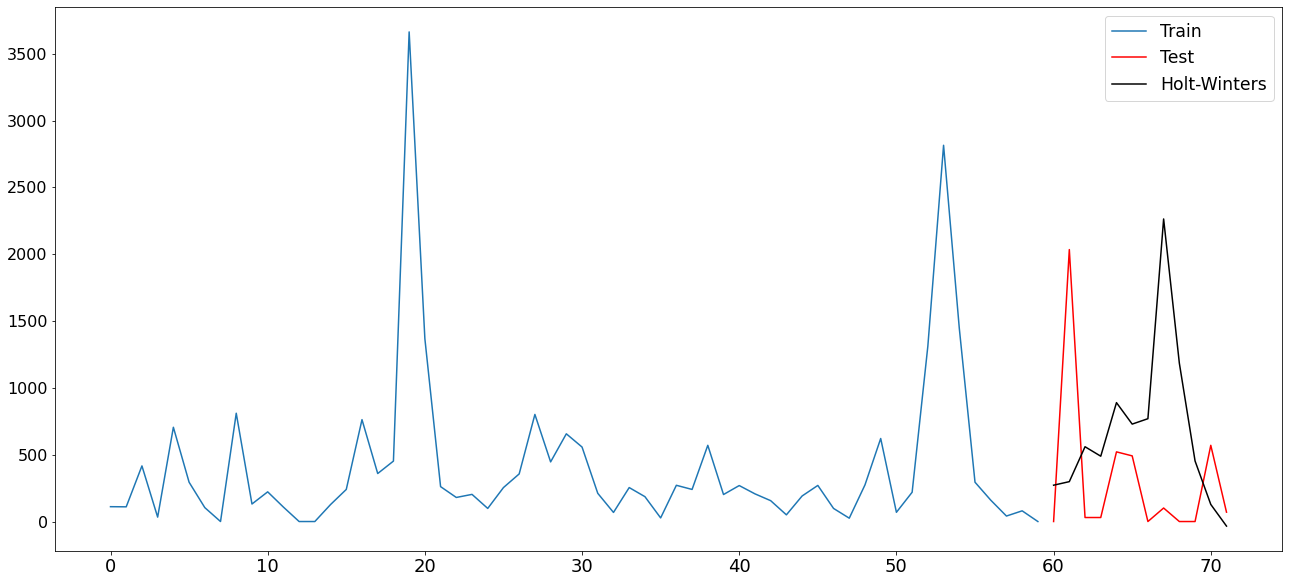

In [ ]:
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

# Scratch

In [ ]:
# iterate through each column and apply PROPHET method
# for each in range(sales_df_pivot.shape[1]):
#     df['ds'] = sales_df_pivot['Date']
#     y = sales_df_pivot.iloc([:, each])
#     df['y'] = y

for each in range(merge_gb_pivot.shape[1]):
    m = Prophet(seasonality_mode='multiplicative')
    df = merge_gb_pivot.iloc[:,each].to_frame().reset_index()
    material = df.columns[1]
    df.columns = ['ds', 'y']
    m.fit(df)
    future = m.make_future_dataframe(periods=24, freq='MS')

    fcst = m.predict(future)
#     fig = m.plot(fcst)
    fcst[{'ds', 'yhat'}]
    
    df2 = fcst[{'ds', 'yhat'}]
    df2.columns = [material, 'Month']
    df2[material] = df2[material].round(0).astype(int)
    df2.set_index('Date')
    
    df3 = merge_gb_pivot.merge(df2, on='Date', how='outer', suffixes=(None,'_y'))
    df3[material] = df3.loc[df3[material] == np.NaN, material] = df3[material+'_y']
    df3 = df3.drop(columns=[material+'_y'])
    
    df3.to_csv("Data/TW_AM_24mo_Prophet_FCST.csv")

ParserError: day is out of range for month: 0

In [ ]:
df3.head(20)

,Date,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,IB00137300,IB00139800,IB00140000,IB00140200,...,TB96906000,TB96906100,TB96908000,TB96908100,TB96909000,TB96909100,TB96910000,TB96910100,TB96962000,TB96962100
0,2016-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-38
1,2016-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-58
2,2016-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11
3,2016-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,2016-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,2016-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4
6,2016-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,101.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
7,2016-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,351.0,377.0,0.0,30.0,0.0,30.0,0.0,30.0,0.0,0
8,2016-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,393.0,62.0,116.0,115.0,110.0,130.0,75.0,0.0,0
9,2016-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,25.0,312.0,406.0,307.0,386.0,301.0,320.0,0.0,-2


In [ ]:
df3 = pd.read_csv("Data/TW_AM_24moFCST.csv")
df3.dtypes

Unnamed: 0      int64
Date           object
IB00095000    float64
IB00095100    float64
IB00099900    float64
               ...   
TB96909100    float64
TB96910000    float64
TB96910100    float64
TB96962000    float64
TB96962100      int64
Length: 366, dtype: object

In [ ]:
### 

In [ ]:
# Below is just reference

In [ ]:
# pivot sold to and material
sales_df_pivot = pd.pivot_table(sales_df_gb,
                           values = 'Invoiced Quantity',
                           index = 'Date',
                           columns = 'Material',
                           aggfunc=np.sum,
                           fill_value = 0
                                )

sales_df_pivot = sales_df_pivot.reset_index()
sales_df_pivot['Date'] = to_datetime(sales_df_pivot['Date'])
sales_df_pivot = sales_df_pivot.set_index('Date')
sales_df_pivot.head()

Material,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,IB00137300,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-04-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-05-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# iterate through each column and apply prophet method
# for each in range(sales_df_pivot.shape[1]):
#     df['ds'] = sales_df_pivot['Date']
#     y = sales_df_pivot.iloc([:, each])
#     df['y'] = y

for each in range(sales_df_pivot.shape[1]):
    m = Prophet(seasonality_mode='multiplicative')
    df = sales_df_pivot.iloc[:,each].to_frame().reset_index()
    material = df.columns[1]
    df.columns = ['ds', 'y']
    m.fit(df)
    future = m.make_future_dataframe(periods=24, freq='MS')

    fcst = m.predict(future)
#     fig = m.plot(fcst)
    fcst[{'ds', 'yhat'}]
    
    df2 = fcst[{'ds', 'yhat'}]
    df2.columns = [material, 'Date']
    df2[material] = df2[material].round(0).astype(int)
    df2.set_index('Date')
    
    df3 = sales_df_pivot.merge(df2, on='Date', how='outer', suffixes=(None,'_y'))
    df3[material] = df3.loc[df3[material] == np.NaN, material] = df3[material+'_y']
    df3 = df3.drop(columns=[material+'_y'])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

In [ ]:
df3.head(20)

,Date,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
0,2015-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
1,2015-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
2,2015-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56
3,2015-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
4,2015-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43
5,2015-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42
6,2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25
7,2015-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
8,2015-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42
9,2015-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30


,Date,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
82,2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
83,2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2,NaN,NaN,NaN
84,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-25,NaN,NaN,NaN
85,2022-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-40,NaN,NaN,NaN
86,2022-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-28,NaN,NaN,NaN
87,2022-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4,NaN,NaN,NaN
88,2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-13,NaN,NaN,NaN
89,2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-6,NaN,NaN,NaN
90,2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-5,NaN,NaN,NaN
91,2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2,NaN,NaN,NaN


In [ ]:
# rename specs Object column to Material
specs1_df = specs_df.rename(columns={"Object":"Material"})

# merge specs into sales data frame
merged_df = pd.merge(sales_df, specs1_df, on="Material", how="left")

In [ ]:
# group and pivot invoiced quantity by date, sold-to, and material
# split Month into separate month and year components
sales_df[["Month", "Year"]] = sales_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
sales_df["Date"] = sales_df["Year"] + "-" + sales_df["Month"]

# group by date, sold-to, material
sales_df_gb = sales_df.groupby(
    ["Date","Sold-to pt", "Material"],
)[["Invoiced Quantity"]].sum()

# pivot sold to and material
sales_df_pivot = pd.pivot_table(sales_df_gb,
                                values = 'Invoiced Quantity',
                                index = 'Date',
                                columns = ['Sold-to pt', 'Material'],
                                aggfunc=np.sum,
                                fill_value = 0
                               )

sales_df_pivot.head(20)

Sold-to pt    1000014                                                         \
Material   IB00026200 IB00100000 IB00136200 IB75077200 IB75501000 IB75665000   
Date                                                                           
2015-01             0          0          0          0          0          0   
2015-02             0          0          0          0          0          0   
2015-03             0          0          0          0          0          0   
2015-04             0          0          0          0          0          0   
2015-05             0          0          0          0          0          0   
2015-06             0          0          0          0          0          0   
2015-07             0          0          0          0          0          0   
2015-08             0          0          0          0          0          0   
2015-09             0          0          0          0          0          0   
2015-10             0          0          0          0          0          0   
2015-11             0          0          0          0          0          0   
2015-12             0          0          0          0          0          0   
2016-01             0          0          0          0          0          0   
2016-02             0          0          0          0          0          0   
2016-03             0          0          0          0          0          0   
2016-04             0          0          0          0          0          0   
2016-05             0          0          0          0          0          0   
2016-06             0          0          0          0          0          0   
2016-07             0          0          0          0          0          0   
2016-08             0          0          0          0          0          0   

Sold-to pt                                              ...    2000030  \
Material   TB00017200 TB00017400 TB00017500 TB00017600  ... TB96906500   
Date                                                    ...              
2015-01             0          0          0          0  ...          0   
2015-02             0          0          0          0  ...          0   
2015-03             0          0          0          0  ...          0   
2015-04             0          0          0          0  ...          0   
2015-05             0          0          0          0  ...          0   
2015-06             0          0          0          0  ...          0   
2015-07             0          0          0          0  ...          0   
2015-08             0          0          0          0  ...          0   
2015-09             0          0          0          0  ...          0   
2015-10             0          0          0          0  ...          0   
2015-11             0          0          0          0  ...          0   
2015-12             0          0          0          0  ...          0   
2016-01             0          0          0          0  ...          0   
2016-02             0          0          0          0  ...          0   
2016-03             0          0          0          0  ...          0   
2016-04             0          0          0          0  ...          0   
2016-05             0          0          0          0  ...          0   
2016-06             0          0          0          0  ...          0   
2016-07             0          0          0          0  ...          0   
2016-08             0          0          0          0  ...          0   

Sold-to pt                                                                    \
Material   TB96906600 TB96908000 TB96908100 TB96909000 TB96909100 TB96910000   
Date                                                                           
2015-01             0          0          0          0          0          0   
2015-02             0          0          0          0          0          0   
2015-03             0          0          0          0  

In [ ]:
# reduce down to necessary columns
reduced_df = merged_df[["Material", "Sold-to pt", "Month", "Invoiced Quantity", 
                        "Product hierarchy.1", "Application_x", "Tire Size", "Ply Construction",
                        "Bead", "Color", "TPI - Threads per inch", "Compound", "Technology"
                       ]]

# rename columns
reduced_df = reduced_df.rename(columns={"Product hierarchy.1":"Product hierarchy",
                                        "Application_x":"Application"})

# split tire size by diameter (before x) and width (after x)
reduced_df[["Diameter", "Width"]] = reduced_df["Tire Size"].str.split("X", n=1, expand=True)

# splite Month into separate month and year components
reduced_df[["Month", "Year"]] = reduced_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
reduced_df["Date"] = reduced_df["Year"] + "/" + reduced_df["Month"]

# strip erroneous text from diameter and width
reduced_df["Diameter"] = reduced_df["Diameter"].str.replace(r'"','')
reduced_df["Width"] = reduced_df["Width"].str.replace(r'"','')

# drop application Tubes and MVS
# reduced_df = reduced_df[reduced_df["Application"].str.contains("TUBE|MVS")==False]

#Displaying Cleaned Dataframe
reduced_df

# Output to excel for review
# reduced_df.to_excel('Output/output.xlsx')

In [ ]:
# groupby date, material
groupby_df = reduced_df.groupby(["Date","Material"],
                              as_index=False)[["Date","Material","Invoiced Quantity"]].sum()

for each in groupby_df["Material"]
bymaterial_df = groupby_df

In [ ]:
# Holt Winters ETS forecasting for total sales by month

fc_df = soldto_df

fit_model = ETS(fc_df["Invoiced Quantity"],trend="mul",seasonal="mul",seasonal_periods=12).fit()

fc_future = fit_model.forecast(24).round()

fc_df["Forecast"] = fit_model.fittedvalues()

fc_df["Forecast"] = fc_df["Forecast"].round()

fc_df
# # append forecasted values onto onto model
# fc1521_df = pd.DataFrame({"Forecast": fc1519_df["Forecast"].append(fc2021)})

# # merge forecasted dataframe with actual sales data frame
# fcm_df = fc_df.merge(fc1521_df, how='outer', left_index=True, right_index=True)

# print(f"MSE: {mse_test}")
# print(f"MAE: {mae_test}")

In [ ]:
# group by material create a time series for each material for invoiced quantity by month

date_df = reduced_df.groupby(["Date"], as_index = False)[["Date", "Invoiced Quantity"]].sum()                     

# Prelimiary plot to quickly visualize overall
plt.plot(date_df["Date"], date_df["Invoiced Quantity"])
plt.title("Total sales quantity by month")

plt.show()
plt.savefig("Output/Total sales quantity by month.png")

In [ ]:
# group by year and month then sum invoiced quantity
year_month_df = reduced_df.groupby(["Year", "Month"],
                                   as_index = False)[["Year", "Month", "Invoiced Quantity"]].sum()

year_month_df

In [ ]:
# Holt Winters ETS forecasting for total sales by month

fc_df = year_month_df

fc1519_df = fc_df.loc[(fc_df['Year'] == "2015")|
          (fc_df['Year'] == "2016")|
          (fc_df['Year'] == "2017")|
          (fc_df['Year'] == "2018")|
          (fc_df['Year'] == "2019"), :]

fit_model = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit()

fc2021 = fit_model.forecast(24).round()

fc1519_df["Forecast"] = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit().fittedvalues

fc1519_df["Forecast"] = fc1519_df["Forecast"].round()

# plot the forecasted model
fc_df["Invoiced Quantity"].plot(legend=True, label="Actual")
fc2021.plot(legend=True, label="Predicted")
fc1519_df["Forecast"].plot(legend=True, label="HWTES",
                          title="Forecasted Monthly Sales Volume (2015-2021)",
                          ylabel="Quantity Sold",
                          xlabel="Month")

plt.savefig("Output/Forecasted Quantity by Month.png")

# mean squared error and mean average error
mse_test = mse(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])
mae_test = meanabs(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])

# append forecasted values onto onto model
fc1521_df = pd.DataFrame({"Forecast": fc1519_df["Forecast"].append(fc2021)})

# merge forecasted dataframe with actual sales data frame
fcm_df = fc_df.merge(fc1521_df, how='outer', left_index=True, right_index=True)

# original data ends at 2021/10 so adding dates to the bottom
fcm_df.at[82,"Year"]= "2021"
fcm_df.at[83,"Year"]= "2021"
fcm_df.at[82,"Month"]= "11"
fcm_df.at[83,"Month"]= "12"

print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")

In [ ]:
# Group forecasts by year
fcm_yr_df = fcm_df.groupby(["Year"],
                           as_index = False)[["Year","Invoiced Quantity","Forecast"]].sum()

fcm_yr_df.to_csv("Output/forecast_by_year.csv", index = False)

fcm_yr_df

In [ ]:
#chi testing data from combined_year
forcast_chi = {'year': ['2020','2021'],
         'expected': [184502,192619], 'observed':[168569,315350]}

forcast_chi_df = pd.DataFrame(forcast_chi)

forcast_chi_df.to_csv("Output/forcast_chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

pvalue = st.chisquare(forcast_chi_df['observed'], forcast_chi_df['expected'])

print(critical_value)
print(pvalue)

forcast_chi_df

In [ ]:
#chi testing data from combined_year
forcast_chi = {'year': ['2018','2019'],
         'expected': [170569.0,177373.0], 'observed':[175695,168569.0]}

forcast_chi_df = pd.DataFrame(forcast_chi)

forcast_chi_df.to_csv("Output/forcast_chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

pvalue = st.chisquare(forcast_chi_df['observed'], forcast_chi_df['expected'])

print(critical_value)
print(pvalue)

forcast_chi_df

In [ ]:
# Find years and months, 
# create a dataframe containing the summed quantities for each date 
# with months in rows and years in columns

years = year_month_df["Year"].unique()
months = {"Month": year_month_df["Month"].unique()}
yearly_df = pd.DataFrame(months)

for each in years:
    df = year_month_df.loc[year_month_df['Year'] == each]
    df = df[["Month","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    yearly_df = pd.merge(yearly_df, df, on="Month", how="left" )      

yearly_df

In [ ]:
# plot quantity by month for each year
for each in years:
    plt.plot(yearly_df["Month"], yearly_df[each], label = each)

plt.title("Quantity Sold by Month")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.legend(title="Year")
plt.title("Yearly Quantity vs over the Months")
plt.grid()
plt.show()

plt.savefig("Output/YearlyQuantitybymonthyear.png")

In [ ]:
#using .groupby() and .sum() to get the year to invoiced quantity total
combined_year = year_month_df.groupby(['Year'])['Invoiced Quantity'].sum().reset_index()
combined_year

In [ ]:
#dropping year 2020 and 2021 during the covid year before calculating lineregression.
combined_year_drop = combined_year.drop([5,6])
combined_year_drop

In [ ]:
#setting up the linear regression and line for the scatter plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year_drop["Year"].astype(int),combined_year_drop["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year_drop["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year_drop.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year_drop['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.title("Invoiced Quantity vs Year (pre-covid)")
plt.savefig("Output/Invoiced Quantity vs Year (pre-covid).png")
plt.show()

In [ ]:
#setting up the linear regression and line for the scatter plot for 7 years including covid
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year["Year"].astype(int),combined_year["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.title("Invoiced Quantity vs Year (with covid)")
plt.savefig("Output/Invoiced Quantity vs Year (with covid).png")
plt.show()

In [ ]:
# quantity sold grouped by application

application_df = reduced_df.groupby(["Application","Year"],
                                   as_index = False)[["Application","Year","Invoiced Quantity"]].sum()

# arrange chart with years in the columns
years = application_df["Year"].unique()
applications = {"Application": application_df["Application"].unique()}
application_year_df = pd.DataFrame(applications)

for each in years:
    df = application_df.loc[application_df['Year'] == each]
    df = df[["Application","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    application_year_df = pd.merge(application_year_df, df, on="Application", how="left" )      

application_year_df.to_csv("Output/application_year_df.csv", index = False)
application_year_df

In [ ]:
# plot sales by application by year

application_year_df.set_index("Application").plot(kind='bar',figsize=(20,10), stacked = True)

plt.title("Quantity Sold by Application")
plt.xlabel('Application')
plt.ylabel('Invoiced Quantity')

plt.legend(['2015',
            '2016',
            '2017',
            '2018',
            '2019',
            '2020',
            '2021',
           ])
plt.title("Invoiced Quantity vs Application over the years")
plt.savefig("Output/Invoiced Quantity vs Application over the years.png")
plt.show()

In [ ]:
# group sales by for forecast application by year

diameter_df = reduced_df.groupby(["Application","Diameter","Year","Month"],
                                   as_index = False)[["Application","Diameter",
                                                      "Year","Month",
                                                      "Invoiced Quantity"]].sum()

diameter_mountain_df = diameter_df.loc[diameter_df['Application'] == "MOUNTAIN"]

diameter_275_df = diameter_mountain_df.loc[diameter_df['Diameter'] == "27.5"]
diameter_29_df = diameter_mountain_df.loc[diameter_df['Diameter'] == "29"]
diameter_275_df = diameter_275_df[["Year","Month","Invoiced Quantity"]].reset_index(drop=True)
diameter_275_df = diameter_275_df.rename(columns=({"Invoiced Quantity":"27.5"}))
diameter_29_df = diameter_29_df[["Invoiced Quantity"]].reset_index(drop=True)
diameter_29_df = diameter_29_df.rename(columns=({"Invoiced Quantity":"29"}))
year_diameter_df = diameter_275_df.merge(diameter_29_df,
                                         how='outer', left_index=True, right_index=True)

year_diameter_df

In [ ]:
# Holt Winters Triple Exponential Smoothing forecasting

fc_diameter_df = year_diameter_df

# filter out only 2015-2019 for training data
fc_diameter_1519_df = fc_diameter_df.loc[(fc_diameter_df['Year'] == "2015")|
                                         (fc_diameter_df['Year'] == "2016")|
                                         (fc_diameter_df['Year'] == "2017")|
                                         (fc_diameter_df['Year'] == "2018")|
                                         (fc_diameter_df['Year'] == "2019"), :]

# 27.5 forecast
fit_diameter_model_275 = ETS(fc_diameter_1519_df["27.5"],
                             trend="mul",seasonal="mul", damped_trend=True,
                             seasonal_periods=12).fit()

fc_diameter_2021_275 = fit_diameter_model_275.forecast(24).round()

fc_diameter_1519_df["27.5 Forecast"] = fit_diameter_model_275.fittedvalues

fc_diameter_1519_df["27.5 Forecast"] = fc_diameter_1519_df["27.5 Forecast"].round()


# 29 forecast
fit_diameter_model_29 = ETS(fc_diameter_1519_df["29"],
                            trend="mul",seasonal="mul", damped_trend=True,
                            seasonal_periods=12).fit()

fc_diameter_2021_29 = fit_diameter_model_29.forecast(24).round()

fc_diameter_1519_df["29 Forecast"] = fit_diameter_model_29.fittedvalues

fc_diameter_1519_df["29 Forecast"] = fc_diameter_1519_df["29 Forecast"].round()

# plot the forecasted model
fc_diameter_df["27.5"].plot(legend=True, label="27.5 Actual")
fc_diameter_2021_275.plot(legend=True, label="27.5 Predicted")
fc_diameter_df["29"].plot(legend=True, label="29 Actual")
fc_diameter_2021_29.plot(legend=True, label="29 Predicted")
plt.title("Forecasted Sales Volume 27.5 vs 29 (2015-2021)")
plt.ylabel("Quantity Sold")
plt.xlabel("Month")
plt.grid('both')
plt.show()

plt.savefig("Output/Forecasted Diameter.png")

# mean squared error and mean average error
mse_test = mse(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])
mae_test = meanabs(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])

# append forecasted values onto onto model
fc_diameter_1521_275_df = pd.DataFrame({"27.5 Forecast":fc_diameter_1519_df["27.5 Forecast"].append(fc_diameter_2021_275)})
fc_diameter_1521_29_df = pd.DataFrame({"29 Forecast":fc_diameter_1519_df["29 Forecast"].append(fc_diameter_2021_29)})

# merge forecasted dataframe with actual sales data frame
fcmd_df = fc_diameter_df.merge(fc_diameter_1521_275_df, how='outer', left_index=True, right_index=True)
fcmd_df = fcmd_df.merge(fc_diameter_1521_29_df, how='outer', left_index=True, right_index=True)

# original data ends at 2021/10 so manually adding dates to the bottom
fcmd_df.at[82,"Year"]= "2021"
fcmd_df.at[83,"Year"]= "2021"
fcmd_df.at[82,"Month"]= "11"
fcmd_df.at[83,"Month"]= "12"

print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")

In [ ]:
# Group forecasts by year
fcmd_yr_df = fcmd_df.groupby(["Year"],
                           as_index = False)[["Year",
                                              "27.5", "27.5 Forecast",
                                              "29", "29 Forecast"]].sum()

fcmd_yr_df['29 Actual %'] = (fcmd_yr_df['29'] / (fcmd_yr_df['29'] + fcmd_yr_df['27.5']) * 100).round(1)
fcmd_yr_df['29 Predicted %'] = (fcmd_yr_df['29 Forecast'] / (fcmd_yr_df['29 Forecast'] + fcmd_yr_df['27.5 Forecast']) * 100).round(1)

fcmd_yr_df.to_csv("Output/diameter_forecast_by_year.csv", index = False)

fcmd_yr_df = fcmd_yr_df.set_index("Year")

fcmd_yr_df

In [ ]:
# plot forecast vs actual

fcmd_yr_df['29 Predicted %'].plot(legend=True, label="% 29 Predicted")
fcmd_yr_df['29 Actual %'].plot(legend=True, label="% 29 Actual")

plt.xlabel('Year')
plt.ylabel('% of 29 vs 27.5')
plt.title('% of 29 diameter vs 27.5 by year')
plt.savefig("Output/29v275.png")
plt.grid('both')
plt.show()

In [ ]:
#chi testing data from combined_year
chi = {'year': ['2019', '2020'],
         'observed': [59.8,64.4], 'expected':[55.5,54.0]
        }

chi_df = pd.DataFrame(chi)

chi_df.to_csv("Output/chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

print(f"Critical Value = {critical_value}")
print(st.chisquare(chi_df['observed'], chi_df['expected']))

chi_df

In [ ]:
# Secondary diameter group by specifically for plot below
diameter_df = reduced_df.groupby(["Application","Diameter","Year"],
                                   as_index = False)[["Application","Diameter","Year",
                                                      "Invoiced Quantity"]].sum()

diameter_mountain_df = diameter_df.loc[diameter_df['Application'] == "MOUNTAIN"]

diameter_mountain_df = diameter_mountain_df[["Diameter","Year","Invoiced Quantity"]]

years = diameter_mountain_df["Year"].unique()
diameters = {"Diameter": diameter_mountain_df["Diameter"].unique()}
diameter_year_df = pd.DataFrame(diameters)

for each in years:
    df = diameter_mountain_df.loc[diameter_mountain_df['Year'] == each]
    df = df[["Diameter","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    diameter_year_df = pd.merge(diameter_year_df, df, on="Diameter", how="left" )

# diameter_year_df

year_diameter_df = diameter_year_df.transpose()

year_diameter_df.columns=year_diameter_df.iloc[0]
year_diameter_df = year_diameter_df[1:]
year_diameter_df = year_diameter_df.rename(columns={"Diameter":"Year"})

year_diameter_df.to_csv("Output/year_diameter_df.csv", index = False)

year_diameter_df

In [ ]:
# plot quantity by diameter for each year
diameter_year_df.set_index("Diameter").transpose().plot(kind='bar')

plt.xlabel('Year')
plt.ylabel('Invoiced Quantity')
plt.title('Year vs Invoiced Quantity')
plt.savefig("Output/Year vs Invoiced Quantity.png")
plt.show()

In [ ]:
#Percent change usind .pct_change()
pct_chng_diameter = diameter_year_df.set_index("Diameter").transpose().pct_change().fillna(0)

pct_chng_diameter.to_csv("Output/pct_chng_diameter.csv", index = False)

pct_chng_diameter

In [ ]:
#figure of percent change
pct_chng_diameter.plot()
plt.xlabel('Year')
plt.ylabel('Percent Change in Quantity')
plt.title('Year vs Percent Change in Quantity')
plt.savefig("Output/Year vs Percent Change in Quantity.png")